<a href="https://colab.research.google.com/github/Velmor/Genomic-Data-Clustering/blob/main/Genomic_Data_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the libraries

In [1]:
import pandas as pd

import numpy as np

from tqdm import tqdm

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

In [2]:
from sklearn.preprocessing import StandardScaler

Data Preparation

In [5]:
with open ("/content/sample_data/ccrescentus.fa","r") as inputFile:
  data=inputFile.readlines()

#open the file and get an array

In [6]:
#first line in the file is description, so we concatenate each line from the second

geneticCode=''

for line in data[1:]:
  geneticCode+=line.strip()


In [7]:
#count the presence of each genome (a,c,g,t)

aCount=geneticCode.count('a')

cCount=geneticCode.count('c')

gCount=geneticCode.count('g')

tCount=geneticCode.count('t')

In [8]:
#testing: to see if there is a character that we don’t want

print(geneticCode[0:30])

if(aCount+cCount+gCount+tCount==len(geneticCode)):
  print("it’s okay")

else:
  print("you should delete something")


gccgatagcctatgatccccggcaggcccg
it’s okay


Converting text into a numerical table

Creating Frequency Tables
Now we've got a string element containing the sequence. The word is any continuous piece of text that contains several subsequent letters. As there are no spaces in the text, separation into words is not unique. The next step is to separate it into smaller sub-strings and create frequency tables for each x-sized word. We start by separating the string into a number of sub-strings, of a reasonable sample size, to become rows on our table.

What is a "reasonable size" for a data point?

Knowing that our string has 30k characters, and that we are checking words with a maximum of 4 - 5 letters, take a size of 300. It generates 1k data points, and allows for 60 5-letter words. It seams reasonable, but do feel free to change it and see the impact. We clip the whole text into fragments of 300 letters 4 in length and calculate the frequencies of short words (of length 1–4) inside every fragment. This will give us a description of the text in the form of a numerical table. There will be four such tables for every short word length choice from 1 to 4.

As there are only four letters, there are four possible words of length 1 (singlets), 16 = 4^2 possible words of length 2 (duplets), 64 = 4^3 possible words of length 3 (triplets) and 256 = 4^4 possible words of length 4 (quadruplets). The first table contains four columns (frequency of every singlet) and the number of rows equals the number of fragments. The second table has 16 columns and the same number of rows, and so on.

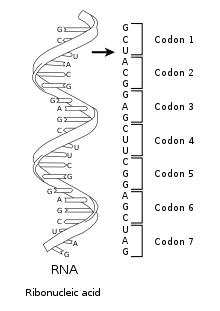

In [9]:
#size of subs trings (data points)

size=300

dataPoints=[]

#copying the entire code into a string, which will be removed on its first elements iteratively

tempString=geneticCode

#iteratively removing the left chunk of the string and place it into a array

while len(tempString)>0:
  dataPoints.append(tempString[0:size])

  tempString=tempString[size:]

print(dataPoints[0])

gccgatagcctatgatccccggcaggcccggggcttggagccgtctggtttggatggaaccctccaaaccagatcaagaggctcctagaacgccgcccgcagggtcacgccccaggtgcgcgggtcgcccggctggccggcgatcaggccggtgttgctgggacccacggccagttgctcgaaatagttctcgtcgaaggcgttgcggacccaggcatagaggttcagcccctcaggcgtgcggaagccggcccggaagttagcgatcgtgtagccgtcaacccaggtgtagatcgaggg


Creating a list with the combinations of word possible

In [10]:
import itertools

In [11]:
iterables= ['a','g','t','c']

wordsDict={}

#for words of size 1 to 4, we calculate the cartesian product to get all the possibilities

for i in range(1,5):
  words=[]

  iterator=itertools.product(iterables,repeat=i)

  for word in iterator:
    s=''
    for t in word:
      s+=t
    words.append(s)
  wordsDict[i]=words

#print the dict for length of 3
print(wordsDict[3])

['aaa', 'aag', 'aat', 'aac', 'aga', 'agg', 'agt', 'agc', 'ata', 'atg', 'att', 'atc', 'aca', 'acg', 'act', 'acc', 'gaa', 'gag', 'gat', 'gac', 'gga', 'ggg', 'ggt', 'ggc', 'gta', 'gtg', 'gtt', 'gtc', 'gca', 'gcg', 'gct', 'gcc', 'taa', 'tag', 'tat', 'tac', 'tga', 'tgg', 'tgt', 'tgc', 'tta', 'ttg', 'ttt', 'ttc', 'tca', 'tcg', 'tct', 'tcc', 'caa', 'cag', 'cat', 'cac', 'cga', 'cgg', 'cgt', 'cgc', 'cta', 'ctg', 'ctt', 'ctc', 'cca', 'ccg', 'cct', 'ccc']


Now,we create a DataFrame to begin the frequency matrix construction. Allwe need to do is to apply the count functon for each word and store it as a new column. We do this for all 4 sizes of words.

In [13]:
#dictonary that will contain the frequency table for each word size

freqTables={}

for i in range(1,5):
  df=pd.DataFrame(columns=wordsDict[i]) #create empty dataframe with columns being the words of dict

  for index, dataP in enumerate(dataPoints):
    df.loc[index]=np.zeros(len(wordsDict[i]))  #create a row with zero values corresponding to a data point

    while len(dataP)>0:
      left=dataP[0:i] #get the left part  of the data point (i characters)

      df.loc[index,left] += 1 #find it in the respective column and count it there

      dataP=dataP[i:]

  freqTables[i]=df

freqTables[3].head()

,aaa,aag,aat,aac,aga,agg,agt,agc,ata,atg,...,cgt,cgc,cta,ctg,ctt,ctc,cca,ccg,cct,ccc
0,0.0,1.0,0.0,3.0,0.0,2.0,0.0,2.0,2.0,0.0,...,2.0,2.0,2.0,1.0,1.0,4.0,4.0,4.0,1.0,1.0
1,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,5.0,0.0,...,2.0,4.0,0.0,2.0,4.0,2.0,1.0,1.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,2.0,4.0,0.0,4.0,5.0,4.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,4.0,0.0,5.0,5.0,2.0,2.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,...,2.0,2.0,0.0,8.0,3.0,1.0,5.0,1.0,0.0,0.0


In [16]:
#run PCA (principal component analysis)  to normalize data across columns
#i do this to have same averages and same dispersions across the data, which is important concept of both PCA and k-means as they are distance-based algorithms
#The Standars Scaler function is used to achieve this.

normFreqTables={}

for i in range(1,5):
  #eliminating the string column from the data, leaving only the actual frequencies

  data=freqTables[i]

  data=StandardScaler(copy=True,with_mean=True,with_std=True).fit_transform(data)

  normFreqTables[i]=pd.DataFrame(data,columns=wordsDict[i])

#testing, checking that the average of a column is close to zero and the SD is close to 1

print(normFreqTables[2].loc[:,'gt'].mean())

print(normFreqTables[2].loc[:,'gt'].std())

-1.1178646776953396e-16
1.0004920049498167


In [17]:
pca=PCA(n_components=2)

pCompTables={}

for i in range(1,5):
  pca.fit(normFreqTables[i])

  pComponents=pca.transform(normFreqTables[i])

  pCompTables[i]=pd.DataFrame(pComponents[:,[0,1]],columns=['pc1','pc2'])

  print('Explained variance for'+str(i)+'letters:'+str(pca.explained_variance_ratio_.sum()))

print(pCompTables[2].head())

Explained variance for1letters:0.7489363490534273
Explained variance for2letters:0.22788833224830085
Explained variance for3letters:0.3167020193818015
Explained variance for4letters:0.02934404192736883
        pc1       pc2
0 -0.977731 -0.448233
1 -0.098351 -0.880433
2  1.178586  0.319942
3  0.545119  1.125241
4  0.078999  1.732124


In [18]:
#we need to plot this tables to try to find correlations visually

import matplotlib.pyplot as plt


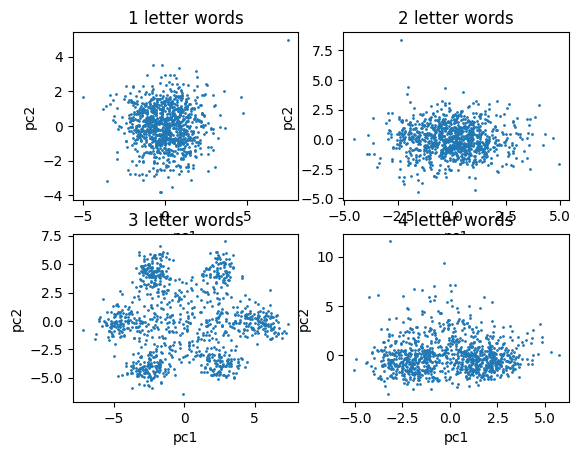

In [19]:
for i in range(1,5):
    plt.subplot(2,2,i)
    x = pCompTables[i].loc[:,'pc1']
    y = pCompTables[i].loc[:,'pc2']
    plt.scatter(x,y, s = 1)
    plt.xlabel('pc1')
    plt.ylabel('pc2')
    plt.title(str(i) + ' letter words')

plt.show()

In [20]:
kmeans = KMeans(n_clusters = 7)
kmeans.fit(normFreqTables[3])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=7)

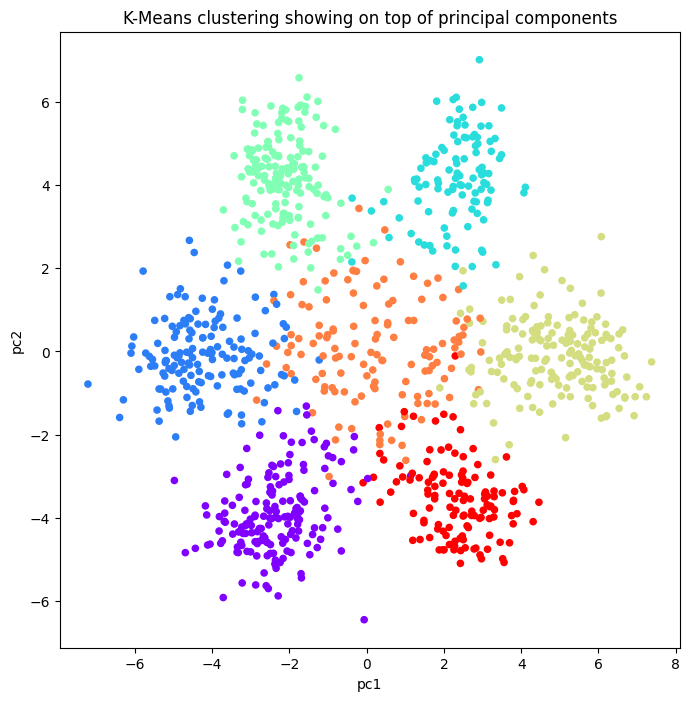

In [21]:
plt.figure(figsize=(8,8))

x = pCompTables[3].loc[:,'pc1']
y = pCompTables[3].loc[:,'pc2']
plt.scatter(x,y, s = 20, c=kmeans.labels_, cmap = 'rainbow')
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.title('K-Means clustering showing on top of principal components')

plt.show()

Hence, Unsupervised Learning through Clustering (K-means Clustering) and Dimensionality Reduction (PCA) has allowed us to visualize, validate and provide supporting evidence for the biological discovery that the DNA genetic sequence is organized into three-letter words called codons, which are actually responsible for the amino acids and proteins that are produced by living cells.